In [1]:
import numpy as np 
import pandas as pd 
import spacy 
import re

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.parse.corenlp import CoreNLPParser 

from dotenv import load_dotenv
import os
import google.generativeai as genai 

import seaborn as sb 
import matplotlib.pyplot as plt 

import xml.etree.ElementTree as ET

In [2]:
df = pd.read_csv("complexSrs.csv") 
print(df)

                                               sentence
0     The key guiding principle behind the functiona...
1     CCTNS V1.0 functionality is designed to focus ...
2     After a complaint is initiated, police initiat...
3     The Investigation module of the CCTNS facilita...
4     Interfacing with the courts during the prosecu...
...                                                 ...
4340  Each of the Help topic pop-up windows will con...
4341  The system shall display “[system name] Overvi...
4342  The system must allow users to easily navigate...
4343  The system must exhibit each of the help pages...
4344  The system shall provide searching ability to ...

[4345 rows x 1 columns]


In [3]:
class LingAnalyser: 
    def __init__(self): 
        self.MIN_SENT_LEN = 3 
        self.MAX_SENT_LEN = 40
        self.MIN_CLAUSE = 1
        self.MAX_CLAUSE = 3
        self.nlp = spacy.load("en_core_web_sm") 

    def analyseSent(self,txt): 
        words = self.nlp(txt)
        len_sent = len(words)
        len_clause =  sum(1 for word in words if word.dep_ in ("ROOT", "advcl", "ccomp", "xcomp", "relcl", "csubj")) 
        inconsistent_punct = self.check_punctuation_consistency(txt) 
        result={
            "isValid":True,
            "Complexity":"simple",
            "sent_len": len_sent, 
            "clause_count":len_clause,
            "SimplificationSuggested":False,
            "inconsistent_punct":inconsistent_punct
        }
        
        if(len_sent<self.MIN_SENT_LEN or len_clause<self.MIN_CLAUSE ): 
            result["isValid"]=False 
            return result
        
        if(len_clause>1 and len_clause<=self.MAX_CLAUSE): 
            result["Complexity"]="medium"
        if(len_sent>self.MAX_SENT_LEN or len_clause>self.MAX_CLAUSE) : 
            result["Complexity"]="complex"
            result["SimplificationSuggested"]=True
            
        return result

    def check_punctuation_consistency(self,txt):
        words = self.nlp(txt)
        issues = []
    
        # missing end punctuation
        for sent in words.sents:
            if sent.text.strip()[-1] not in ".?!":
                issues.append("Missing end punctuation.")
    
        # Multiple spaces
        if re.search(r'\s{2,}', txt):
            issues.append("Double or extra spaces.")
    
        # Space before punctuation
        if re.search(r'\s[,.?!]', txt):
            issues.append("Space before punctuation mark.")
    
        # Imbalanced quotes
        if txt.count('"') % 2 != 0:
            issues.append("Unbalanced double quotes.")
        if txt.count("'") % 2 != 0:
            issues.append("Unbalanced single quotes.")
    
        return issues

        
    def printDepTree(self,txt): 
        words = nlp(txt)
        spacy.displacy.render(words, style="dep", jupyter=True)
    def print_tree(self,token, level=0):
        print(" - -" * level + f"{token.text}({token.dep_})")
        for child in token.children:
            self.print_tree(child, level + 1) 
    def printParseTree(self,txt): 
        words = nlp(txt)
        for word in words:
            if word.dep_ == "ROOT":
                self.print_tree(word)
        
    def getSimplerVersion(self,txt):
        load_dotenv()  # loads .env automatically
        api_key = os.getenv("GEMINI_API_KEY")
        genai.configure(api_key=api_key)
        
        model = genai.GenerativeModel("gemini-2.5-flash")
        
        prompt = f"""You are a text simplification agent. Your job is to simplify text provided and return the simplified sentence.
        The provided text might contain multilple clauses. The simplified sentences shouldn't contain more than 3 clauses per sentence and
        the sentence lenght shouldn't be more than 40. You are allowed to split sentences to multiple sentences to achieve this.
        provide no other text with the response.
        Input_text:\"{txt}\""""
        
        response = model.generate_content(prompt)
        return response.text

In [14]:
file = open("gemini_output.txt",'w') 
file.write("Hi"+" what\n")
file.write("hi")
file.close()

In [18]:
la = LingAnalyser() 
file = open("gemini_output.txt",'w') 
for s in df["sentence"][75:105]: 
    # print(s)
    # la.printDepTree(s)
    # la.printParseTree(s)
    # # print(la.analyseSent(s)) 
    # if(la.analyseSent(s)["SimplificationSuggested"]):
    file.write("sentence: \""+s+" \"\n")
    file.write("Simplified: \""+la.getSimplerVersion(s)+" \"\n") 
    file.write("*******************\n")
file.close()

In [163]:
raw_data = [] 
tree = ET.parse("./XMLZIPFile/0000 - cctns.xml")
root = tree.getroot() 
text = [elem.text.strip() for elem in root.iter() if elem.text and elem.text.strip()]
[raw_data.append(t) for t in text]
sentences = [] 
for c in raw_data:
    [sentences.append(s) for s in sent_tokenize(c)]
finalSrsDf = pd.DataFrame({"sentence":sentences}) 
finalSrsDf.to_csv("./srs.csv",index=False)

In [19]:
srs = pd.read_csv("srs.csv") 

In [20]:
la = LingAnalyser() 

sent_lens=[] 
clause_counts = []
isValid = [] 
complexities = [] 
inconsistent_punct = []

for s in srs["sentence"]: 
    inf = la.analyseSent(str(s))
    isValid.append(inf["isValid"])
    if(inf["isValid"]==False) : continue
    sent_lens.append(inf["sent_len"])
    clause_counts.append(inf["clause_count"]) 
    complexities.append(inf["Complexity"])
    [inconsistent_punct.append(inc) for inc in inf["inconsistent_punct"]]

# print(sent_lens)
# print(clause_counts)
# print(isValid)
# print(complexities)

In [175]:
# For isolating complex sentences 

la = LingAnalyser() 
ComplexSentences = [] 

for s in srs["sentence"]: 
    inf = la.analyseSent(str(s))
    isValid.append(inf["isValid"])
    if(inf["isValid"]==False) : continue
    if(inf["Complexity"] != "simple") : 
        ComplexSentences.append(s) 

ComplexSrs = pd.DataFrame({"sentence":ComplexSentences}) 
ComplexSrs.to_csv("./complexSrs.csv",index=False)

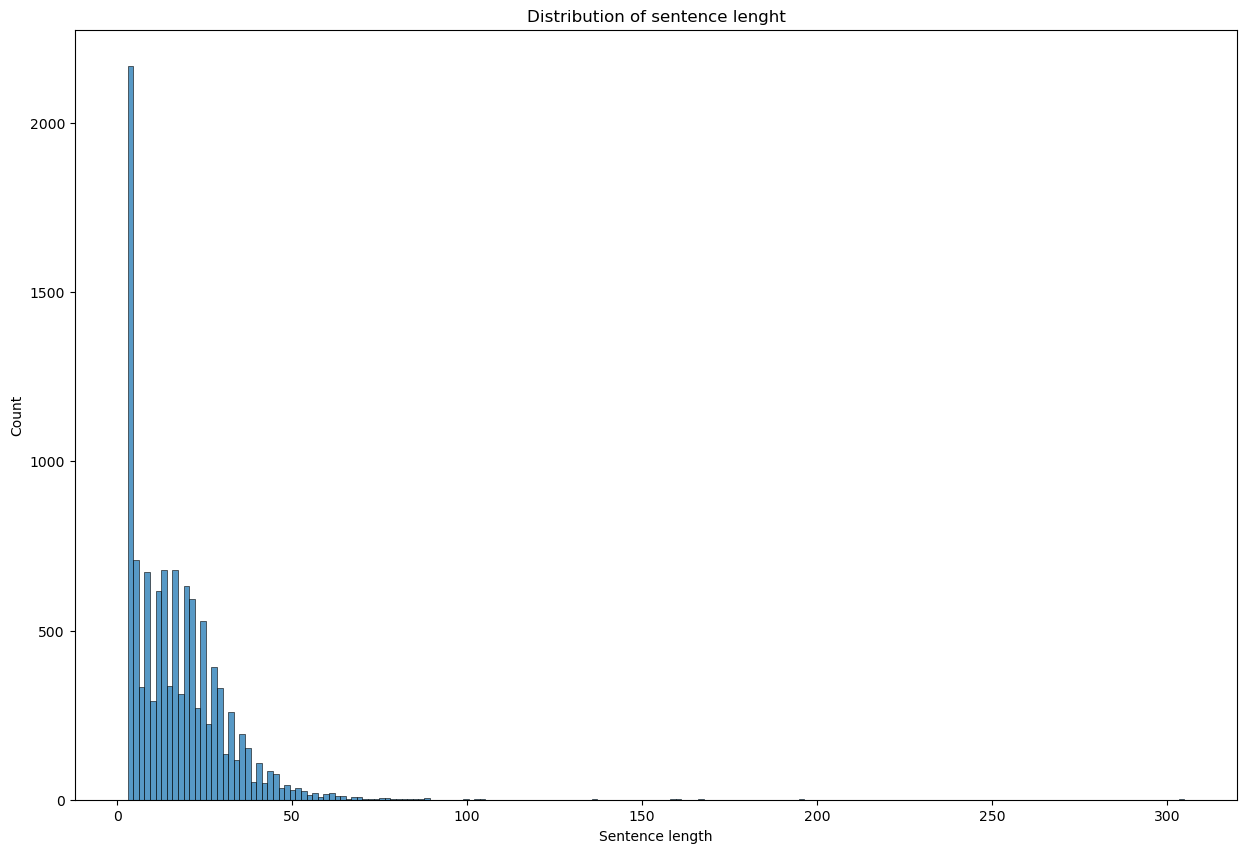

In [21]:
plt.figure(figsize=(15,10))
sb.histplot(sent_lens) 
plt.xlabel("Sentence length") 
plt.title("Distribution of sentence lenght") 
plt.show()

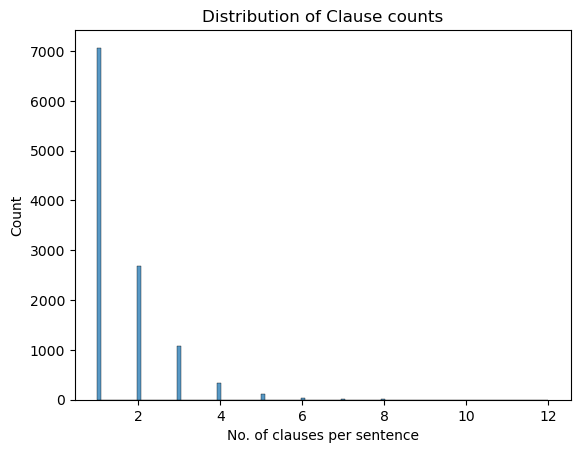

In [22]:
sb.histplot(clause_counts) 
plt.xlabel("No. of clauses per sentence") 
plt.title("Distribution of Clause counts")
plt.show()

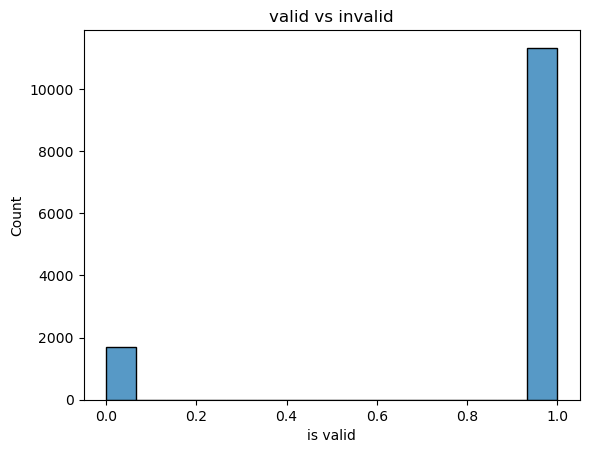

In [23]:
sb.histplot(isValid) 
plt.xlabel("is valid") 
plt.title("valid vs invalid")
plt.show()

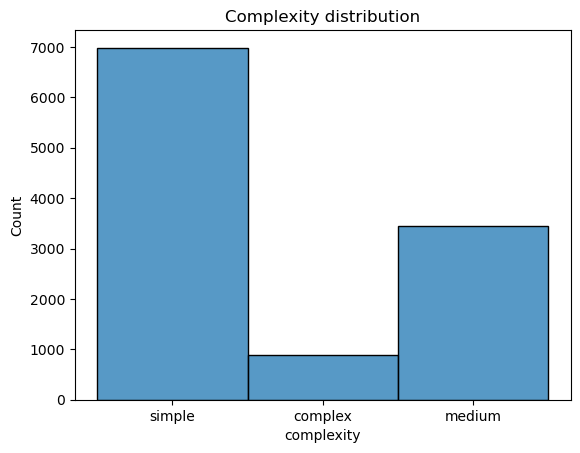

In [24]:
sb.histplot(complexities) 
plt.xlabel("complexity") 
plt.title("Complexity distribution")
plt.show()

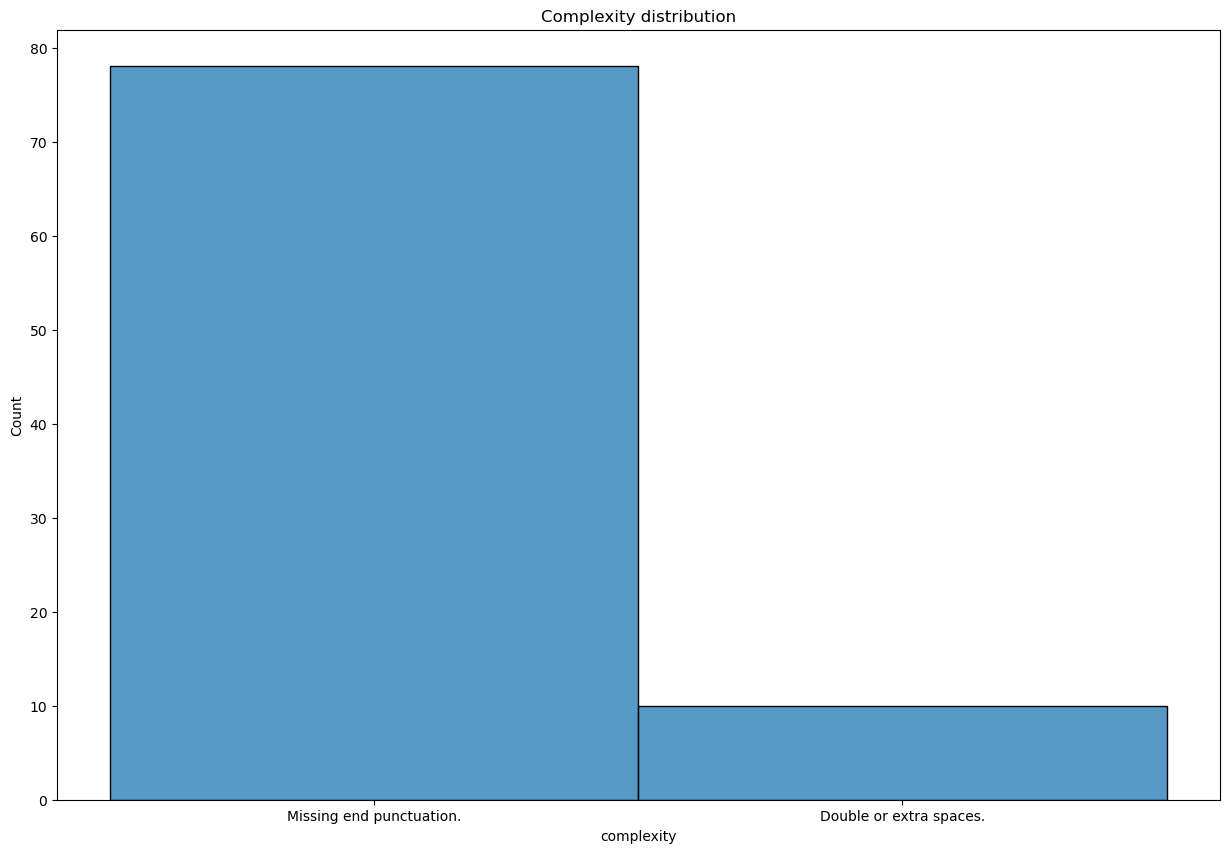

In [170]:
plt.figure(figsize=(15,10))
sb.histplot(inconsistent_punct) 
plt.xlabel("complexity") 
plt.title("Complexity distribution")
plt.show()

In [12]:
Cmap ={
    "simple":1, 
    "medium":2, 
    "complex":3
}
files = ["./XMLZIPFile/0000 - cctns.xml"
        ,"./XMLZIPFile/0000 - gamma j.xml"
        ,"./XMLZIPFile/1995 - gemini.xml"
        ,"./XMLZIPFile/1998 - themas.xml"
        ,"./XMLZIPFile/1999 - dii.xml"
        ,"./XMLZIPFile/1999 - tcs.xml"
        ,"./XMLZIPFile/2003 - qheadache.xml"
        ,"./XMLZIPFile/2005 - microcare.xml"
        ,"./XMLZIPFile/2005 - phin.xml"
        ,"./XMLZIPFile/2006 - eirene sys 15.xml"
        ,"./XMLZIPFile/2007 - get real 0.2.xml"
        ,"./XMLZIPFile/2007-eirene_fun_7-2.xml"
        ,"./XMLZIPFile/2007-ertms.xml"
        ,"./XMLZIPFile/2008 - keepass.xml"
        ,"./XMLZIPFile/2008 - peering.xml"
        ,"./XMLZIPFile/2009 - peppol approved.xml"
        ,"./XMLZIPFile/2009 - video search.xml"
        ,"./XMLZIPFile/2010-blitdraft.xml"
        ]

for f in files: 
    raw_data = [] 
    tree = ET.parse(f)
    root = tree.getroot() 
    text = [elem.text.strip() for elem in root.iter() if elem.text and elem.text.strip()]
    [raw_data.append(t) for t in text] 
    sentences = [] 
    for c in raw_data:
        [sentences.append(s) for s in sent_tokenize(c)]
    la = LingAnalyser() 

    sent_lens=[] 
    clause_counts = []
    isValid = [] 
    complexities = [] 
    inconsistent_punct = []
    
    for s in sentences: 
        inf = la.analyseSent(str(s))
        isValid.append(inf["isValid"])
        if(inf["isValid"]==False) : continue
        sent_lens.append(inf["sent_len"])
        clause_counts.append(inf["clause_count"]) 
        complexities.append(Cmap[inf["Complexity"]]) 
        if(len(inf["inconsistent_punct"])>0): 
            inconsistent_punct.append(1)
    print(f," ********************************* ") 
    n=len(sentences)
    print("Sentence length:",n) 
    print("Valid Sentences:",isValid.count(True)) 
    print("Invalid Sentences:",isValid.count(False)) 
    print("Average sentence lenght:",sum(sent_lens)/n) 
    print("Average Clause count:",sum(clause_counts)/n) 
    print("Average Complexity score:",sum(complexities)/n) 
    print("Punctuation consistency:", ((n-len(inconsistent_punct))/n)*100)
    
    


./XMLZIPFile/0000 - cctns.xml  ********************************* 
Sentence length: 280
Valid Sentences: 262
Invalid Sentences: 18
Average sentence lenght: 19.15714285714286
Average Clause count: 1.8178571428571428
Average Complexity score: 1.5785714285714285
Punctuation consistency: 71.78571428571429
./XMLZIPFile/0000 - gamma j.xml  ********************************* 
Sentence length: 794
Valid Sentences: 533
Invalid Sentences: 261
Average sentence lenght: 7.42191435768262
Average Clause count: 0.9118387909319899
Average Complexity score: 0.8740554156171285
Punctuation consistency: 75.31486146095719
./XMLZIPFile/1995 - gemini.xml  ********************************* 
Sentence length: 1600
Valid Sentences: 1409
Invalid Sentences: 191
Average sentence lenght: 15.978125
Average Clause count: 1.434375
Average Complexity score: 1.323125
Punctuation consistency: 34.3125
./XMLZIPFile/1998 - themas.xml  ********************************* 
Sentence length: 493
Valid Sentences: 359
Invalid Sentences

In [14]:
raw_data = [] 

newdf = pd.read_csv("output.csv")

sent_lens=[] 
clause_counts = []
isValid = [] 
complexities = [] 
inconsistent_punct = []

for s in newdf["model_output"]: 
    inf = la.analyseSent(str(s))
    isValid.append(inf["isValid"])
    if(inf["isValid"]==False) : continue
    sent_lens.append(inf["sent_len"])
    clause_counts.append(inf["clause_count"]) 
    complexities.append(Cmap[inf["Complexity"]]) 
    if(len(inf["inconsistent_punct"])>0): 
        inconsistent_punct.append(1)

<Axes: ylabel='Count'>

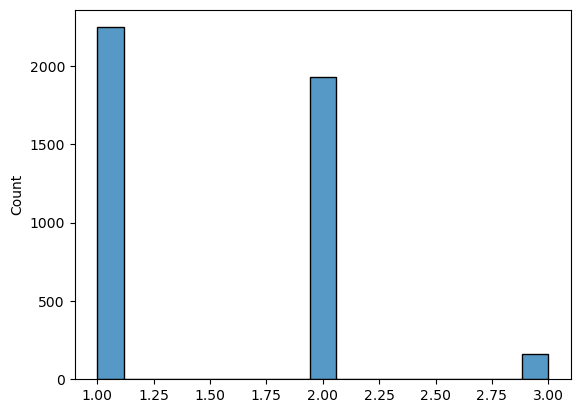

In [15]:
sb.histplot(complexities)

In [13]:
newdf = pd.read_csv("output.csv") 
print(newdf)

                                               sentence  \
0     The key guiding principle behind the functiona...   
1     CCTNS V1.0 functionality is designed to focus ...   
2     After a complaint is initiated, police initiat...   
3     The Investigation module of the CCTNS facilita...   
4     Interfacing with the courts during the prosecu...   
...                                                 ...   
4340  Each of the Help topic pop-up windows will con...   
4341  The system shall display “[system name] Overvi...   
4342  The system must allow users to easily navigate...   
4343  The system must exhibit each of the help pages...   
4344  The system shall provide searching ability to ...   

                                           model_output  
0     The key principle is to focus on important fun...  
1     CCTNS helps police, record keepers, and citize...  
2                 Police investigate after a complaint.  
3     The module helps with investigations and makes...  
4